<a href="https://www.kaggle.com/code/shivansh2503/image-compression?scriptVersionId=249053398" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import torch

import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/image1/may.jpeg


In [2]:
img = Image.open("/kaggle/input/image1/may.jpeg")
print("Image Size: ",img.size)
print("Image Mode: ",img.mode)
print("Image Dimmensions: ", np.array(img).shape)

Image Size:  (783, 1600)
Image Mode:  RGB
Image Dimmensions:  (1600, 783, 3)


In [3]:
# converting to grayscale for faster execution
img_grayscale = img.convert("L")
print("Gray Scale Image Size: ",img_grayscale.size)  #(width, height)
print("Gray Scale Image Mode: ",img_grayscale.mode)
print("Gray Scale Image Dimmensions: ", np.array(img_grayscale).shape) #(height, width)

Gray Scale Image Size:  (783, 1600)
Gray Scale Image Mode:  L
Gray Scale Image Dimmensions:  (1600, 783)


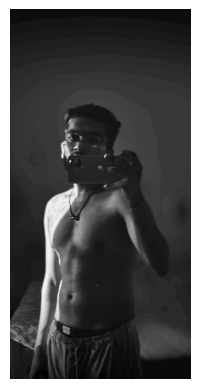

In [4]:
plt.imshow(img_grayscale, cmap="gray")
plt.axis("off")
plt.show()

## Pre processing

### For normalization we using the min,max normalizatoin instead of sklearn because sklearn normalizes rows by their L2 norm and That’s for feature vectors, not pixel values.
$$
X_{\text{normalized}} = (X - \text{min\_val}) \times \frac{(\text{new\_max} - \text{new\_min})}{(\text{max\_val} - \text{min\_val})} + \text{new\_min}
$$

### For 8 bit grayscale image min value = 0, max value = 255 and the target range is [-1, 1] for sin functions to be used therefore new_min = -1, new_max=1

$$
X_{\text{normalized}} = (X - 0) \times \frac{(1 - (-1))}{(255 - 0)} + (-1)
$$

$$
X_{\text{normalized}} = \left(\frac{X}{255}\right) \times 2 - 1
$$

### Hence this formula we'll be using to normalize.

In [5]:
# Converting grayscale image into pixels
image_np = np.array(img_grayscale)

#normalising the image
pixels = (image_np/255.0)*2 -1
print("Initial Shape: ",pixels.shape)

pixels_reshape = pixels.reshape(-1,1)
print("Now Shape: ", pixels_reshape.shape)

Initial Shape:  (1600, 783)
Now Shape:  (1252800, 1)


In [6]:
H, W = image_np.shape

x = np.linspace(-1, 1, W)
y = np.linspace(-1, 1, H)

xx, yy = np.meshgrid(x,y, indexing="xy")

coords = np.stack([xx, yy],axis=-1).reshape(-1, 2)

X = torch.tensor(coords, dtype = torch.float32) # Coordinates flatten -> Given as input to siren
Y = torch.tensor(pixels_reshape, dtype = torch.float32) # GT used for MSE and Back propogation MSE(Y', Y)

## Model building